In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import pickle
import pydicom
from general import DATA_DIR
from metrics import Pfbeta

In [3]:
train = pd.read_csv(DATA_DIR/'train.csv')

# Load experiment

In [4]:
from datasets import *
from architectures import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from transforms import *
from configs import *
# from configs_seg import SegBaseline, SegBaseline2
from kuma_utils.utils import sigmoid
from sklearn.metrics import roc_auc_score

In [5]:
def aggregate_results(cfg):
    with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
        predictions = pickle.load(f)
    res_df = []
    for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
        ds = cfg.dataset(df=train.iloc[folds[1]], image_dir=None)
        for i in range(len(ds)):
            record = ds.df_dict[ds.pids[i]]
            res_df.append({
                'fold': fold_i,
                'pred': sigmoid(pred_fold[i][0]), 
                'prediction_id': f'{ds.pids[i][0]}_{ds.pids[i][1]}'})
    res_df = pd.DataFrame(res_df)
    return res_df

configs_to_export = [
    Aug07(), AuxLoss03(), Aug07pl2aug2(), Aug07mod1(), Aug07lr0(), Res02Aux0(), Res02pl0pr0(), 
]
for icfg, cfg in enumerate(configs_to_export):
    oof_df = aggregate_results(cfg)
    oof_df.to_csv(f'input/rsna-breast-cancer-detection/oofs/kuma_{cfg.name}.csv', index=False)

In [13]:
for icfg, cfg in enumerate(configs_to_export):
    if icfg == 0:
        oof_df = aggregate_results(cfg).rename({'pred': f'{cfg.name}'}, axis=1)
    else:
        oof_df = oof_df.merge(
            aggregate_results(cfg).rename({'pred': f'{cfg.name}'}, axis=1), 
            on=['prediction_id', 'fold'], how='left')

oof_df

,fold,aug_07,prediction_id,aux_03,aug_07_pl2_aug2,aug_07_mod1,aug_07_lr0,res_02_aux0,res_02_pl0_pr0
0,0,0.000440,49_L,0.000693,0.000815,0.000859,0.002173,0.001288,0.001648
1,0,0.000394,49_R,0.000853,0.000814,0.000240,0.001864,0.002302,0.001527
2,0,0.000750,72_L,0.000726,0.000896,0.001979,0.002714,0.000232,0.000935
3,0,0.008924,72_R,0.001076,0.002932,0.001766,0.002600,0.000421,0.001511
4,0,0.000131,105_L,0.000881,0.000349,0.000427,0.001508,0.008842,0.007289
...,...,...,...,...,...,...,...,...,...
23821,3,0.000269,65477_R,0.000318,0.000454,0.000208,0.001559,0.000319,0.000682
23822,3,0.004235,65495_L,0.001542,0.003085,0.001181,0.001712,0.001630,0.000592
23823,3,0.000544,65495_R,0.000272,0.000817,0.000567,0.001139,0.000689,0.000239
23824,3,0.000535,65530_L,0.000576,0.001005,0.001122,0.002427,0.002659,0.001495


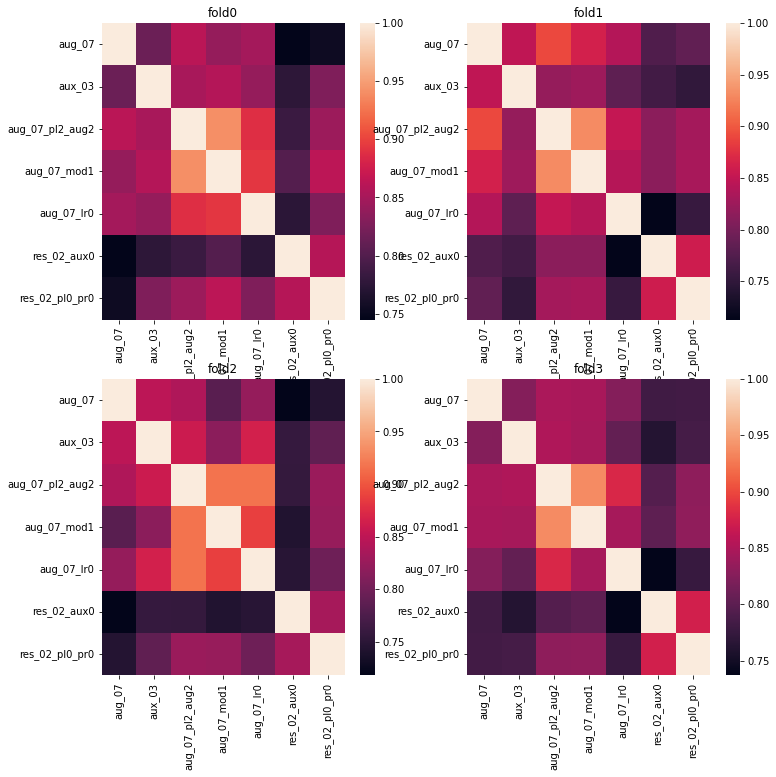

In [18]:
plt.figure(figsize=(12, 12))
for fold, fold_df in oof_df.groupby('fold'):
    plt.subplot(2, 2, fold+1)
    sns.heatmap(fold_df.drop(['fold', 'prediction_id'], axis=1).corr())
    plt.title(f'fold{fold}')
plt.show()

In [5]:
# for fold in range(4):
#     checkpoint = torch.load(f'results/aug_07_pl0_es0/fold{fold}.pt')
#     plt.plot(pd.DataFrame(checkpoint['all_states'])['valid_monitor'].apply(lambda x: x[0]), label=f'fold{fold}')
# plt.legend()
# plt.show()

In [6]:
# def plot_color_gradients(cmap_name):
#     gradient = np.linspace(0, 1, 256)
#     gradient = np.vstack((gradient, gradient))
#     # Create figure and adjust figure height to number of colormaps
#     plt.figure(figsize=(10, 1))
#     plt.imshow(gradient, aspect='auto', cmap=plt.cm.get_cmap(cmap_name))
#     plt.axis('off')

# plot_color_gradients('jet')

In [7]:
# cfg = Dataset02v0()
# ds = PatientLevelDataset(
#     df=train, image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
#     flip_lr=False,
#     preprocess=A.Compose([AutoFlip(), CropROI(threshold=0.1, buffer=160), A.Resize(768, 384)]),
#     transforms=ToTensorV2(),
#     # preprocess=cfg.preprocess['train'],
#     # transforms=cfg.transforms['train']
# )

In [6]:
cfg = Baseline4()
# model = cfg.model(**cfg.model_params)

In [7]:
with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
    predictions = pickle.load(f)

In [8]:
# train['fold'] = 0
# for fold_i, (train_idx, valid_idx) in enumerate(predictions['folds']):
#     train.loc[valid_idx, 'fold'] = fold_i
# train.to_csv('train_with_fold.csv', index=False)

In [9]:
SAMPLE_ID = {
    42624, 48001, 48514, 2179, 31107, 23554, 13185, 53255, 
    29192, 59530, 64908, 32527, 13845, 59552, 54816, 49954, 
    55330, 59307, 21934, 63536, 23729, 61490, 61874, 16955, 
    46014, 38727, 64456, 50375, 9162, 55755, 25550, 15696, 
    50002, 58195, 10198, 13016, 25050, 31581, 26333, 29664, 
    8289, 3305, 6637, 48493, 58610, 42231, 12282, 9083, 32252, 39677}

In [18]:
metric = Pfbeta(binarize=True)

In [11]:
# for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
#     ds = cfg.dataset(
#         df=train.iloc[folds[1]], 
#         image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
#         is_test=True,
#         preprocess=cfg.preprocess['test'],
#         transforms=ToTensorV2())
#     labels = ds.get_labels().reshape(-1)
#     pred = sigmoid(pred_fold).reshape(-1)
#     hard_samples = np.argsort(np.abs(labels - pred))[::-1][:20]
#     for idx in hard_samples:
#         img, label = ds[idx]
#         plt.figure(figsize=(12, 4))
#         plt.suptitle(f'{ds.pids[idx]}/ {label[0].item()}/ {pred[idx]:5f}')
#         for i in range(img.shape[0]):
#             plt.subplot(1, img.shape[0], i+1)
#             plt.imshow(img[i, 0], cmap='gray')
#         # plt.show()
#         plt.savefig(f'input/plot2/fold{fold_i}_{idx}.png', facecolor='white')
#         plt.close()
#     # scores, thres = metric.optimal_f1_all(labels, pred)
#     # plt.plot(scores)
#     # plt.title(f'fold{fold_i} MAX: {max(scores):.5f} AUC: {sum(scores):.5f}')
#     # plt.show()

In [14]:
def aggregate_results(cfg):
    with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
        predictions = pickle.load(f)
    metric = Pfbeta(binarize=True)
    res_df = []
    for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
        ds = cfg.dataset(
            df=train.iloc[folds[1]], image_dir=None)
        for i in range(len(ds)):
            record = ds.df_dict[ds.pids[i]]
            res_df.append({
                'pred': sigmoid(pred_fold[i][0]), 
                'label': record['cancer'].values[0],
                'site': record['site_id'].values[0],
                'machine_id': record['machine_id'].values[0]})
    res_df = pd.DataFrame(res_df)
    return res_df


def subgroup_analysis(df, col='site'):
    res = [{
        'value': f'{col}_overall', 
        'PF1': metric.optimal_f1(df['label'].values, df['pred'].values) if df['label'].sum() > 0 else 'NaN',
        'AUC': roc_auc_score(df['label'].values, df['pred'].values) if df['label'].sum() > 0 else 'NaN'
    }]
    for gid, gdf in df.groupby(col):
        res.append({
            'value': f'{col}_{gid}', 
            'PF1': metric.optimal_f1(gdf['label'].values, gdf['pred'].values) if gdf['label'].sum() > 0 else 'NaN',
            'AUC': roc_auc_score(gdf['label'].values, gdf['pred'].values) if gdf['label'].sum() > 0 else 'NaN'
        })
    res = pd.DataFrame(res)
    return res


def sensitivity_analysis(configs, num_trials=100, sample_count=5000):
    profiles = []
    metric = Pfbeta(binarize=True)
    for cfg in configs:
        agg_df = aggregate_results(cfg)
        score, threshold = metric.optimal_f1(agg_df['label'].values, (agg_df['pred']))
        profiles.append({
            'config': cfg.name, 
            'result': agg_df,
            'threshold': threshold,
        })
    num_samples = len(profiles[0]['result'])
    res = []
    for i in tqdm(range(num_trials)):
        sample_idx = np.random.choice(np.arange(num_samples), sample_count, replace=False)
        res_i = {'trial': i}
        for cfg in profiles:
            sample_df = cfg['result'].iloc[sample_idx]
            target = sample_df['label'].values
            pred = (sample_df['pred'].values > cfg['threshold']).astype(float)
            res_i[cfg['config']] = metric.pfbeta(target, pred)
        res.append(res_i)
    return pd.DataFrame(res)

In [15]:
sens_res = sensitivity_analysis([Aug07(), Aug07pl2aug2(), Res02Aux0(), Res02pl0pr0(), AuxLoss03()], sample_count=5000)

  0%|          | 0/100 [00:00<?, ?it/s]

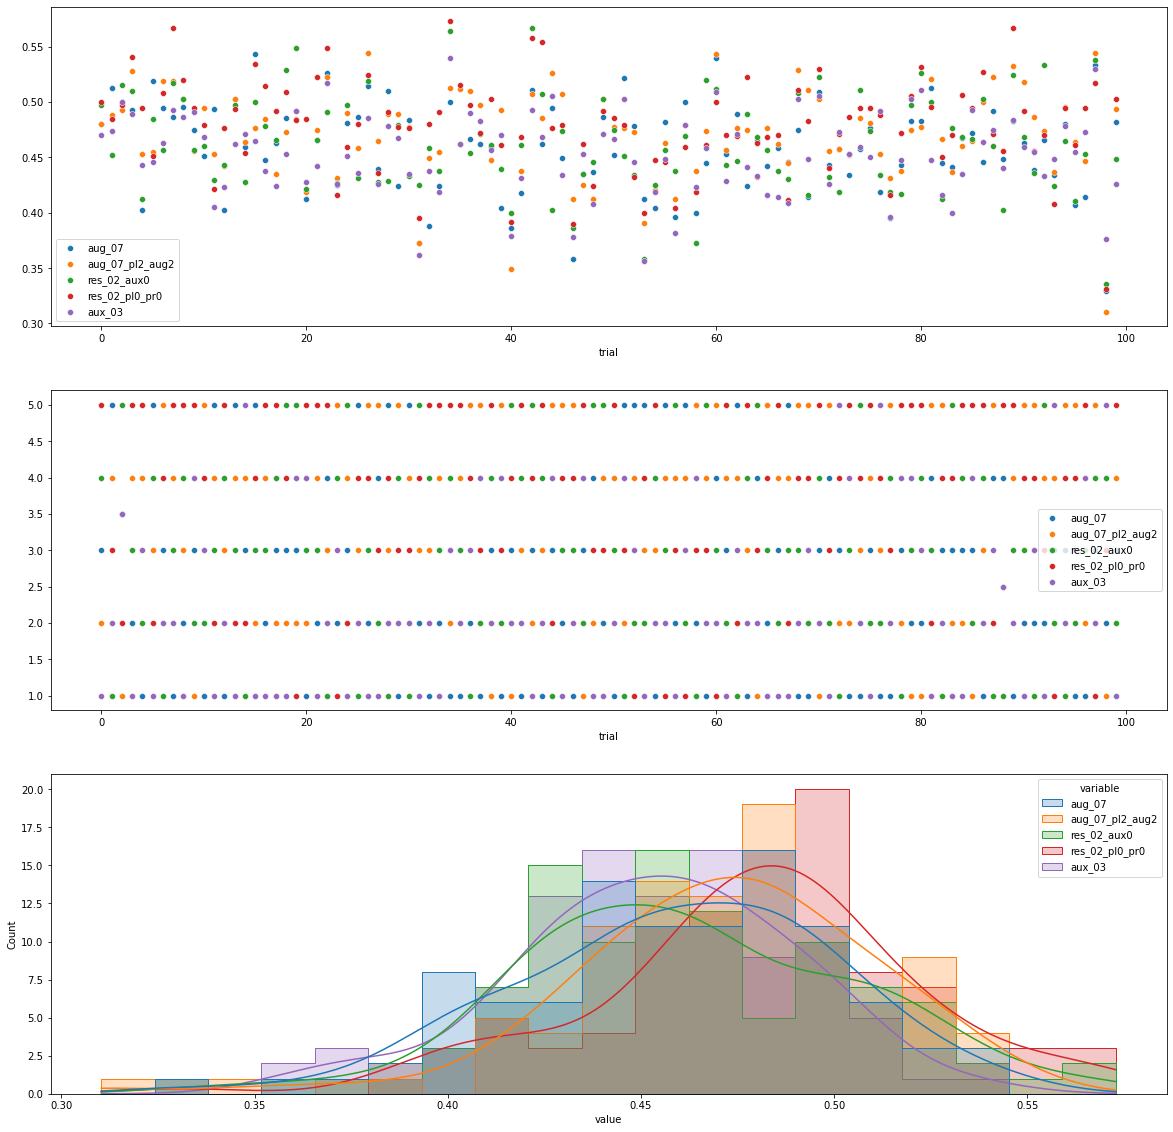

In [16]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
for col in sens_res.columns:
    if col == 'trial':
        continue
    sns.scatterplot(x=sens_res['trial'], y=sens_res[col].values, label=col, markers='X')
plt.legend()
plt.subplot(3, 1, 2)
for col in sens_res.columns:
    if col == 'trial':
        continue
    sns.scatterplot(x=sens_res['trial'], y=sens_res.drop('trial', axis=1).rank(1)[col].values, label=col, markers='X')
plt.legend()
plt.subplot(3, 1, 3)
sns.histplot(data=sens_res.drop('trial', axis=1).melt(), x='value', hue='variable', kde=True, element="step", legend=True)
# plt.legend()
plt.savefig('sens_res.png', facecolor='white')
# plt.show()

In [15]:
agg_df = aggregate_results(Res02Aux0)
metric.optimal_f1(agg_df['label'].values, (agg_df['pred']))

(0.470723306544202, 0.26)

In [19]:
agg_df = aggregate_results(Aug07pl2aug2())
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.47374062165058944, 0.19)",0.904948
1,site_1,"(0.3807339449541284, 0.24)",0.877522
2,site_2,"(0.5804988662131518, 0.21)",0.927149


,value,PF1,AUC
0,machine_id_overall,"(0.47374062165058944, 0.19)",0.904948
1,machine_id_21,"(0.5954198473282443, 0.21)",0.923716
2,machine_id_29,"(0.5599999999999999, 0.16)",0.927818
3,machine_id_48,"(0.6174496644295302, 0.31)",0.938773
4,machine_id_49,"(0.39493670886075943, 0.26)",0.86656
5,machine_id_93,"(0.33333333333333337, 0.52)",0.779507
6,machine_id_170,"(0.5555555555555556, 0.19)",0.95914
7,machine_id_190,"(0.5, 0.03)",0.960784
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [35]:
agg_df = aggregate_results(Aug07)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.4669703872437358, 0.25)",0.879401
1,site_1,"(0.3711790393013101, 0.25)",0.849230
2,site_2,"(0.5714285714285715, 0.25)",0.904431


,value,PF1,AUC
0,machine_id_overall,"(0.4669703872437358, 0.25)",0.879401
1,machine_id_21,"(0.5217391304347826, 0.18)",0.906191
2,machine_id_29,"(0.5555555555555556, 0.16)",0.907058
3,machine_id_48,"(0.641025641025641, 0.25)",0.905984
4,machine_id_49,"(0.38004750593824227, 0.25)",0.8444
5,machine_id_93,"(0.33333333333333337, 0.84)",0.749676
6,machine_id_170,"(0.5217391304347826, 0.12)",0.934946
7,machine_id_190,"(0.03773584905660378, 0.0)",0.745098
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [28]:
agg_df = aggregate_results(AuxLoss00)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.43645083932853723, 0.3)",0.881930
1,site_1,"(0.36448598130841126, 0.3)",0.844627
2,site_2,"(0.5225653206650832, 0.25)",0.916229


,value,PF1,AUC
0,machine_id_overall,"(0.43645083932853723, 0.3)",0.88193
1,machine_id_21,"(0.5027932960893856, 0.06)",0.923085
2,machine_id_29,"(0.5323741007194244, 0.25)",0.910674
3,machine_id_48,"(0.5655172413793104, 0.35000000000000003)",0.916046
4,machine_id_49,"(0.3869346733668341, 0.3)",0.837247
5,machine_id_93,"(0.33333333333333337, 0.65)",0.833982
6,machine_id_170,"(0.3636363636363636, 0.08)",0.853763
7,machine_id_190,"(0.03773584905660378, 0.0)",0.941176
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [29]:
agg_df = aggregate_results(Res00aug0)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.4675324675324676, 0.42)",0.903614
1,site_1,"(0.375, 0.39)",0.870219
2,site_2,"(0.57002457002457, 0.29)",0.930831


,value,PF1,AUC
0,machine_id_overall,"(0.4675324675324676, 0.42)",0.903614
1,machine_id_21,"(0.6016260162601627, 0.4)",0.936075
2,machine_id_29,"(0.523489932885906, 0.18)",0.905955
3,machine_id_48,"(0.611764705882353, 0.16)",0.950141
4,machine_id_49,"(0.38482384823848237, 0.37)",0.85749
5,machine_id_93,"(0.28571428571428575, 0.77)",0.894942
6,machine_id_170,"(0.5333333333333333, 0.42)",0.945968
7,machine_id_190,"(0.6666666666666666, 0.03)",0.980392
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


# Stability analysis

In [8]:
res = aggregate_results(Baseline4)
res.head()

NameError: name 'aggregate_results' is not defined

In [12]:
metric = Pfbeta(binarize=True)

In [14]:
metric.optimal_f1(res['label'], res['pred'])

(0.43966547192353644, 0.34)

In [15]:
res['pred_bin'] = (res['pred'] > 0.34).astype(int)

In [24]:
scores = []
for i in tqdm(range(1000)):
    res_sample = res.sample(2200*2) # per breast
    scores.append(metric.pfbeta(res_sample['label'].values, res_sample['pred_bin'].values))

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Count'>

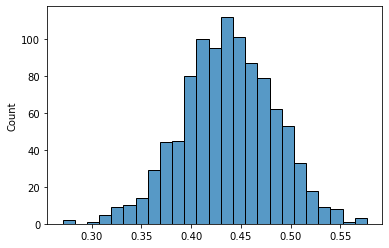

In [25]:
sns.histplot(scores)

# Use metadata ? 

In [17]:
from sklearn.linear_model import LogisticRegression

In [30]:
for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
    ds = cfg.dataset(df=train.iloc[folds[1]], image_dir=None)
    labels = ds.get_labels()
    pred = sigmoid(pred_fold).reshape(-1)
    print(metric.optimal_f1(labels, pred))
    stack_x = pd.DataFrame({
        'pred': pred,
        'age': [ds.df_dict[ds.pids[i]]['age'].values[0] / 100 for i in range(len(ds))]
    })
    stack_x['age'] = stack_x['age'].fillna(stack_x['age'].mean())
    model = LogisticRegression()
    model.fit(stack_x, labels.reshape(-1))
    pred2 = model.predict_proba(stack_x)[:, 1]
    print(metric.optimal_f1(labels, pred2))
    

(0.425, 0.64)
(0.42236024844720493, 0.22)
(0.4174757281553398, 0.13)
(0.4161849710982659, 0.05)
(0.5681818181818182, 0.31)
(0.5654450261780104, 0.05)
(0.5, 0.28)
(0.48837209302325585, 0.09)
(0.42276422764227634, 0.65)
(0.42975206611570244, 0.39)


# Segmentation

In [5]:
from configs_seg import *
from configs import *

def extract_encoder(origin_config, target_config, checkpoint_path, export_path, target='.global_encoder'):
    checkpoint = torch.load(checkpoint_path, 'cpu')
    unet_model = origin_config.model(**origin_config.model_params)
    target_model = target_config.model(**target_config.model_params)
    unet_model.load_state_dict(checkpoint['model'])
    eval(f'target_model{target}').load_state_dict(unet_model.encoder._m.state_dict(), strict=False)
    checkpoint['model'] = target_model.state_dict()
    torch.save(checkpoint, export_path)

In [6]:
# extract_encoder(SegBaseline(), Model12(), 'results/seg_baseline/nocv.pt', 'results/seg_baseline/multi_instance.pt', target='.global_encoder')
# extract_encoder(SegBaseline(), Aug07lr0(), 'results/seg_baseline/nocv.pt', 'results/seg_baseline/multi_view.pt', target='.encoder')

In [7]:
cfg = Model12v1()
# cfg = SegBaseline()
train = pd.read_csv(cfg.train_path).query('cancer == 1')
# train = pd.read_csv(cfg.train_path).query('~finding_birads.isnull()')
dataset = cfg.dataset(
    df=train, 
    image_dir=cfg.image_dir,
    preprocess=cfg.preprocess['test'],
    transforms=cfg.transforms['test'],
    is_test=True,
    **cfg.dataset_params
)

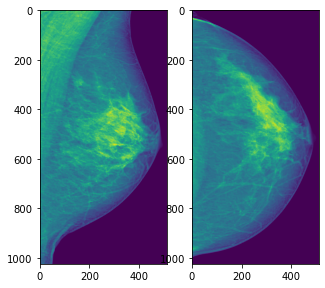

In [79]:
img, label = dataset[0]
_img = (img - img.min()) / (img.max() - img.min())
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(_img[0, 0])
plt.subplot(1, 2, 2)
plt.imshow(_img[1, 0])
plt.show()
plt.close()

In [9]:
model = cfg.model(**cfg.model_params)
checkpoint = torch.load(f'results/{cfg.name}/fold0.pt', 'cpu')['model']
# checkpoint = torch.load(f'results/{cfg.name}/nocv.pt', 'cpu')['model']
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [80]:
model.eval()
with torch.no_grad():
    cam, roi = model.get_global_cam(img[None, :, :, :], return_roi=True)
    # pred = model(img[None, :, :, :])[0]


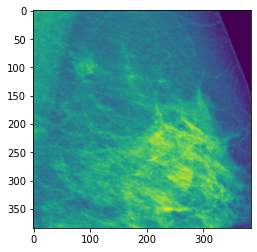

In [152]:
for patch in roi[0]:
    _img = patch[0]
    _img = (_img - _img.amin()) / (_img.amax() - _img.amin() + 1e-4)
    plt.imshow(_img)
    plt.show()